In [114]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/02_critical_ising')

import numpy as np
import matplotlib.pyplot as plt

import torch
import seaborn as sns

import cv2
import time
from tqdm import tqdm

from models.isingCA_localT import isingCA
from src.utils import *

import matplotlib as mpl
mpl.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
ft = 10
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


C:\Users\Heysoos\AppData\Local\Temp\ipykernel_9284\3628946202.py:14: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


# Test

In [2]:
RADIUS=1
BETA=1/(RADIUS * RADIUS)
ca = isingCA(BETA=BETA, RADIUS=RADIUS).cuda() 

(-0.5, 2.5, 2.5, -0.5)

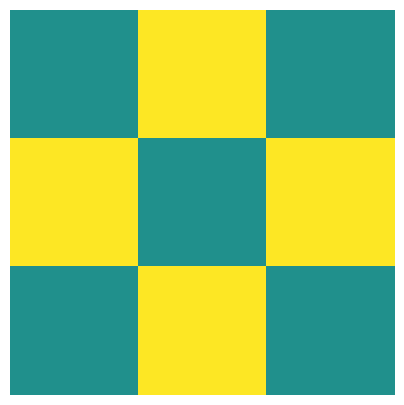

In [3]:
kernels = torch.cat([k for k in ca.rule.nearest_neighbours], dim=0).cpu().detach().numpy()
# kernels = totalistic(ca.rule.kernels[0].cpu().detach()).numpy()

num_plot_kernels = np.min([6, 1])
fig, axes = plt.subplots(1, num_plot_kernels, figsize=(5, 5))

kplot = kernels[0, :, :]
kmax = np.max(np.abs(kplot))
axes.imshow(kplot, vmin=-kmax, vmax=kmax)
axes.axis('off')


t=0/30000, T=1.00000 (1.00000)
t=500/30000, T=0.82624 (0.83514)
t=1000/30000, T=0.84594 (0.87365)
t=1500/30000, T=0.93908 (0.98634)
t=2000/30000, T=1.11279 (1.18582)
t=2500/30000, T=1.27105 (1.36466)
t=3000/30000, T=1.54614 (1.67632)
t=3500/30000, T=1.72043 (1.86815)
t=4000/30000, T=1.90129 (2.06368)
t=4500/30000, T=2.07724 (2.25303)
t=5000/30000, T=2.22693 (2.38919)
t=5500/30000, T=2.30161 (2.41839)
t=6000/30000, T=2.30779 (2.36577)
t=6500/30000, T=2.26176 (2.27357)
t=7000/30000, T=2.21470 (2.19657)
t=7500/30000, T=2.17293 (2.15641)
t=8000/30000, T=2.14344 (2.14760)
t=8500/30000, T=2.14059 (2.14708)
t=9000/30000, T=2.15356 (2.16547)
t=9500/30000, T=2.16785 (2.19169)
t=10000/30000, T=2.17819 (2.19425)
t=10500/30000, T=2.17581 (2.19279)
t=11000/30000, T=2.17016 (2.17763)
t=11500/30000, T=2.16377 (2.17508)
t=12000/30000, T=2.15818 (2.16459)
t=12500/30000, T=2.15483 (2.16388)
t=13000/30000, T=2.15525 (2.16053)
t=13500/30000, T=2.15878 (2.16622)
t=14000/30000, T=2.17087 (2.17909)
t=14500/3

Text(0, 0.5, 'Temperature')

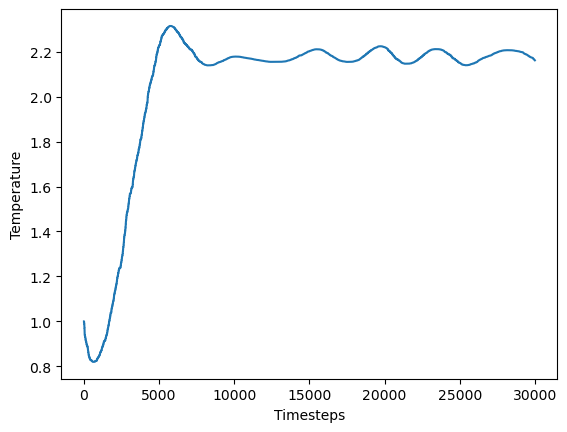

In [4]:
timesteps = 30000
RESX, RESY = 256, 256
print_every = 500

state = state = ca.initGrid((RESX, RESY))
# state[0,-1] *= 0.5

temps = []
with torch.no_grad():
    for t in range(timesteps):
        state = ca.forward(state, temp_adapt=True)
        
        mean_temp = 1 / state[0, -1, ...].mean().cpu().numpy()
        median_temp = 1 / state[0, -1, ...].median().cpu().numpy()
        temps.append(mean_temp)
        if t % print_every == 0:
            print(f't={t}/{timesteps}, T={mean_temp:.5f} ({median_temp:.5f})')
            
plt.plot(temps)
plt.xlabel('Timesteps')
plt.ylabel('Temperature')

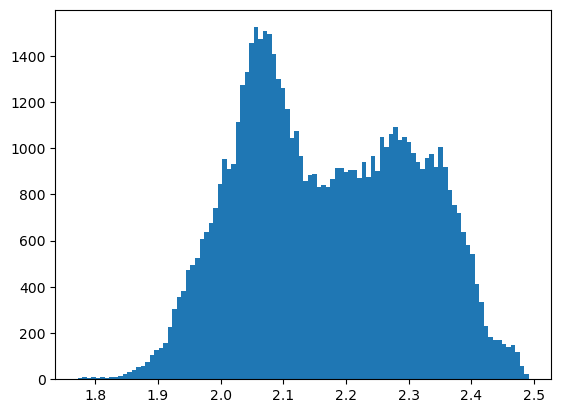

In [5]:
plt.hist(1 / state[0, -1, ...].cpu().numpy().reshape(-1), 100); #plt.yscale('log')

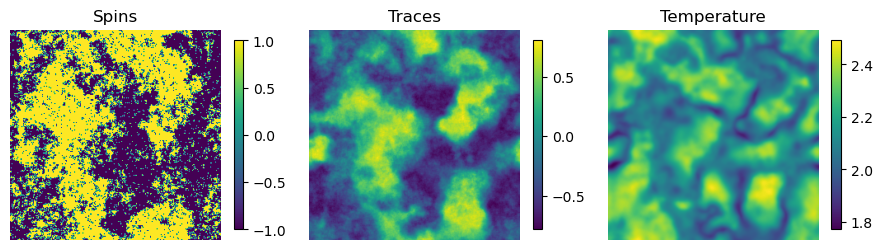

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

ax0_im = ax0.imshow(state[0, 0].cpu().numpy())
ax0.set_title('Spins')
ax0.axis('off')

ax1_im = ax1.imshow(state[0, 1].cpu().numpy())
ax1.set_title('Traces')
ax1.axis('off')

ax2_im = ax2.imshow(1./state[0, -1].cpu().numpy())
ax2.set_title('Temperature')
ax2.axis('off')

shrink=0.7
fig.colorbar(ax0_im, ax=ax0, shrink=shrink)
fig.colorbar(ax1_im, ax=ax1, shrink=shrink)
fig.colorbar(ax2_im, ax=ax2, shrink=shrink)
plt.tight_layout()

### Now do it without temperature adaptation where T is a function of the x-coordinate 

In [150]:
timesteps = 2 * 10 ** 4
RESX, RESY = 1920, 512
print_every = 500

state = state = ca.initGrid((RESX, RESY))
Tc = 2.2691
scale = 0.2
X, Y = torch.meshgrid( Tc * 2 ** torch.linspace(-scale, scale, RESX), RESY/RESX * Tc * 2 ** torch.linspace(-scale, scale, RESY))
state[0,-1] = 1 / X

temps = []
with torch.no_grad():
    for t in range(timesteps):
        state = ca.forward(state, temp_adapt=False)
        
        if t % print_every == 0:
            print(f't={t}/{timesteps}')
            
state_temp_range = state.clone().cpu()

t=0/20000
t=500/20000
t=1000/20000
t=1500/20000
t=2000/20000
t=2500/20000
t=3000/20000
t=3500/20000
t=4000/20000
t=4500/20000
t=5000/20000
t=5500/20000
t=6000/20000
t=6500/20000
t=7000/20000
t=7500/20000
t=8000/20000
t=8500/20000
t=9000/20000
t=9500/20000
t=10000/20000
t=10500/20000
t=11000/20000
t=11500/20000
t=12000/20000
t=12500/20000
t=13000/20000
t=13500/20000
t=14000/20000
t=14500/20000
t=15000/20000
t=15500/20000
t=16000/20000
t=16500/20000
t=17000/20000
t=17500/20000
t=18000/20000
t=18500/20000
t=19000/20000
t=19500/20000


In [341]:
X.min() + (X.max() - X.min()) * 0.05

tensor(2.0069)

In [342]:
timesteps = 2 * 10 ** 4
RESX, RESY = 512, 512
print_every = 500

state = state = ca.initGrid((RESX, RESY))

temp_offset = (X.max() - X.min()) * 0.05

sub_temp = (X.min() + temp_offset).item()
state[0,-1] = 1 / sub_temp

temps = []
with torch.no_grad():
    for t in range(timesteps):
        state = ca.forward(state, temp_adapt=False)
        
        if t % print_every == 0:
            print(f't={t}/{timesteps}')
            
state_cold = state.clone().cpu()

#####################################

state = state = ca.initGrid((RESX, RESY))

super_temp = (X.max() - temp_offset).item()
state[0,-1] = 1 / 2.55

temps = []
with torch.no_grad():
    for t in range(timesteps):
        state = ca.forward(state, temp_adapt=False)
        
        if t % print_every == 0:
            print(f't={t}/{timesteps}')
            
state_hot = state.clone().cpu()

#####################################

state = state = ca.initGrid((RESX, RESY))

state[0,-1] = 1 / Tc

temps = []
with torch.no_grad():
    for t in range(timesteps):
        state = ca.forward(state, temp_adapt=False)
        
        if t % print_every == 0:
            print(f't={t}/{timesteps}')
            
state_crit = state.clone().cpu()

t=0/20000
t=500/20000
t=1000/20000
t=1500/20000
t=2000/20000
t=2500/20000
t=3000/20000
t=3500/20000
t=4000/20000
t=4500/20000
t=5000/20000
t=5500/20000
t=6000/20000
t=6500/20000
t=7000/20000
t=7500/20000
t=8000/20000
t=8500/20000
t=9000/20000
t=9500/20000
t=10000/20000
t=10500/20000
t=11000/20000
t=11500/20000
t=12000/20000
t=12500/20000
t=13000/20000
t=13500/20000
t=14000/20000
t=14500/20000
t=15000/20000
t=15500/20000
t=16000/20000
t=16500/20000
t=17000/20000
t=17500/20000
t=18000/20000
t=18500/20000
t=19000/20000
t=19500/20000
t=0/20000
t=500/20000
t=1000/20000
t=1500/20000
t=2000/20000
t=2500/20000
t=3000/20000
t=3500/20000
t=4000/20000
t=4500/20000
t=5000/20000
t=5500/20000
t=6000/20000
t=6500/20000
t=7000/20000
t=7500/20000
t=8000/20000
t=8500/20000
t=9000/20000
t=9500/20000
t=10000/20000
t=10500/20000
t=11000/20000
t=11500/20000
t=12000/20000
t=12500/20000
t=13000/20000
t=13500/20000
t=14000/20000
t=14500/20000
t=15000/20000
t=15500/20000
t=16000/20000
t=16500/20000
t=17000/2000

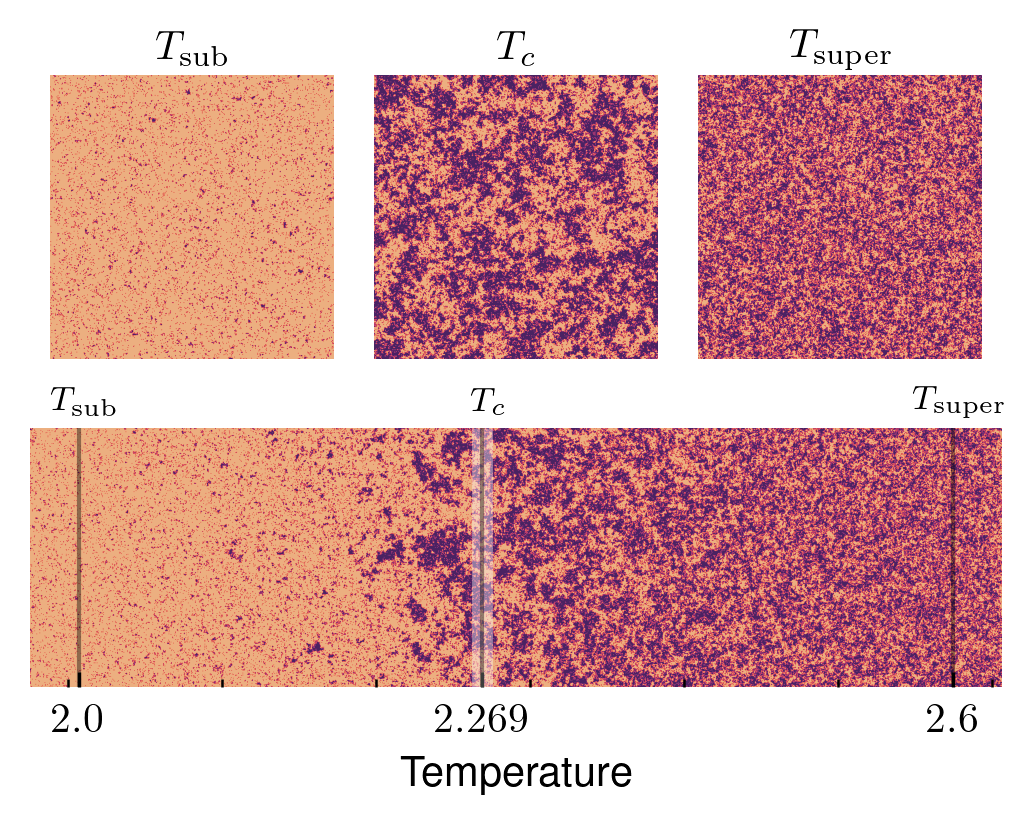

In [359]:
fig_spins = plt.figure(constrained_layout=False, figsize=(12, 2.7), dpi=300)
gs1 = fig_spins.add_gridspec(nrows=2, ncols=3, left=0.0, right=0.27, wspace=0.00)

ax1 = fig_spins.add_subplot(gs1[0, 0])
ax2 = fig_spins.add_subplot(gs1[0, 1])
ax3 = fig_spins.add_subplot(gs1[0, 2])

top_row = [ax1, ax2, ax3]

ax1.imshow(state_cold[0, 0].cpu().numpy().T, extent=[X.min(), X.max(), X.min(), X.max()], cmap='flare')
ax2.imshow(state_crit[0, 0].cpu().numpy().T, extent=[X.min(), X.max(), X.min(), X.max()], cmap='flare')
ax3.imshow(state_hot[0, 0].cpu().numpy().T, extent=[X.min(), X.max(), X.min(), X.max()], cmap='flare')

for ax in top_row:
    ax.axis('off')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4 = fig_spins.add_subplot(gs1[1, :])
ax4.imshow(state_temp_range[0, 0].cpu().numpy().T, extent=[X.min(), X.max(), Y.min(), Y.max()], cmap='flare')

ax = plt.gca()
lw = 5
lw2 = 1
alpha = 0.4
y_min, y_max = ax4.get_ylim()

ax4.vlines(Tc, y_min, y_max, 'w', '-', lw=lw, alpha=alpha, label=rf'$T_c$')
og_major_xticks = list(ax.get_xticks())
og_minor_xticks = list(ax.get_xticks(minor=True))
ax4.set_xticks([sub_temp, Tc, super_temp], minor=False, labels=[rf'${sub_temp:.1f}$', rf'${Tc:.3f}$', rf'${super_temp:.1f}$'])
ax4.set_xticks(og_major_xticks, minor=True, labels=[])
# ax4.tick_params(axis='x', which='minor', bottom=True)
# ax4.set_xticks(og_major_xticks, minor=True, labels=list(ax.get_xticklabels())[1:-1])

# annotate vertical lines with (a,b,c)
top_row_labels = [r"$T_{\mathrm{sub}}$", r"$T_c$", r"$T_{\mathrm{super}}$"]
temp_samples = [sub_temp, Tc, super_temp]

h_spacing = 0.003
ft2 = 8
v_spacing = 1 + ft2 / 50
for i_l, temp in enumerate(temp_samples):
    # vertical line
    ax4.vlines(temp, y_min, y_max, 'k', '-', lw=lw2, alpha=alpha)
    # annotation
    ax4.text(temp + h_spacing, v_spacing, top_row_labels[i_l], color='k', ha='center', va='top',
                transform=ax4.get_xaxis_transform(), fontsize=ft2)

# label the panels
for i_ax, ax in enumerate(top_row):
    ax.annotate(
        top_row_labels[i_ax],
        xy=(0.5, 1), xycoords='axes fraction',
        xytext=(0., +1.1), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', horizontalalignment='center', fontfamily='sans-serif',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

# for label, i_l in enumerate(top_row_labels):
#     ax4.text(2 + h_spacing, v_spacing, label, color='k', ha='center', va='top',
#                 transform=ax4.get_xaxis_transform(), fontsize=ft2)
    # ax4.text(Tc + h_spacing, v_spacing, 'b', color='k', ha='center', va='top',
    #             transform=ax4.get_xaxis_transform(), fontsize=ft2)
    # ax4.text(2.55 + h_spacing, v_spacing, 'c', color='k', ha='center', va='top',
    #         transform=ax4.get_xaxis_transform(), fontsize=ft2)


ax4.set_xlabel(r'Temperature')
ax4.tick_params(
    axis='y',
    which='both',
    left=False,
    labelleft=False,
)

ax4.tick_params(
    axis='x',
    which='both',
    direction='in',
)
sns.despine(ax=ax4, left=True, bottom=True)
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# plt.tight_layout()
plt.savefig('../figures/isingCA_localT.pdf', bbox_inches='tight', dpi=300)